In [21]:
from __future__ import print_function, division

In [2]:
# This changes the current directory to the base saga directory - make sure to run this first!
# This is necessary to be able to import the py files and use the right directories,
# while keeping all the notebooks in their own directory.
import os
import sys

if 'saga_base_dir' not in locals():
    saga_base_dir = os.path.abspath('..')
if saga_base_dir not in sys.path:
    os.chdir(saga_base_dir)

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = (16, 8)
rcParams['image.interpolation'] = 'none'
rcParams['image.origin'] = 'lower'

In [4]:
import urllib2
import datetime

import numpy  as np

from astropy import units as u
from astropy.coordinates import SkyCoord, AltAz, EarthLocation, get_sun
from astropy.time import Time
from astropy.utils.data import get_readable_fileobj
from astropy.io import fits
from astropy.table import Table, QTable, Column, MaskedColumn
from astropy import table

In [5]:
import astroplan

from astroplan import download_IERS_A
download_IERS_A()

In [6]:
for module in ['hosts', 'targeting', 'aat']:
    if module in globals():
        reload(globals()[module])
    else:
        globals()[module] = __import__(module)
#g = targeting.get_gama() #re-caches the gama catalog

In [7]:
hsd = hosts.get_saga_hosts_from_google(clientsecretjsonorfn='client_secrets.json', useobservingsummary=False)
hsd = dict([(h.name, h) for h in hsd])

Using cached version of google hosts list from file "hosts_dl.pkl2"


In [8]:
def catalog_to_sc(cat, hostordist = None):
    if hasattr(hostordist, 'dist'):
        distance = hostordist.dist
    else:
        distance = hostordist
        
    return SkyCoord(cat['ra']*u.deg, cat['dec']*u.deg, distance=distance)

# Initial planning steps 

In [9]:
#if online
ufo = urllib2.urlopen('https://docs.google.com/spreadsheet/ccc?key=1b3k2eyFjHFDtmHce1xi6JKuj3ATOWYduTBFftx5oPp8&output=csv')
hosttab = QTable.read(ufo.read(), format='csv')
ufo.close()

In [10]:
#if offline
#hosttab = Table.read('SAGADropbox/hosts/host_catalog_flag0.csv')

In [11]:
hostscs = SkyCoord(u.Quantity(hosttab['RA'], u.deg), 
                   u.Quantity(hosttab['Dec'], u.deg), 
                   distance=u.Quantity(hosttab['distance'], u.Mpc))

In [12]:
allspec = Table.read('/Users/erik/Dropbox/SAGA/data/allspectaken_v5.fits.gz')

In [13]:
sagaobsed = allspec[~((allspec['TELNAME']=='NSA')|
                      (allspec['TELNAME']=='SDSS')|
                      (allspec['TELNAME']=='GAMA'))]
sagaobsed_nsaids = np.unique(sagaobsed['HOST_NSAID'])

In [14]:
#UTC time from 8:35-19:35 is AAT 18 deg window
nighttimes = Time('2016-7-28 8:45:00') + np.arange(12)*u.hour
aao = EarthLocation(lon='149:3:57.9', lat='-31:16:37.3')
aao_frame = AltAz(obstime=nighttimes, location=aao)

In [15]:
sunaao = get_sun(nighttimes).transform_to(aao_frame)
np.max(sunaao.alt.value)

-15.521588066557504

In [16]:
seczs = []
for sc in hostscs:
    az = sc.transform_to(aao_frame)
    seczs.append(az.secz)
seczs = np.array(seczs)

hrsvis = np.sum((1<=seczs)&(seczs<1.75),axis=1)
visenough = hrsvis>2

In [17]:
aaoobs = astroplan.Observer(aao, 'Australia/NSW')
midnight = aaoobs.midnight(Time('2016-7-28'))

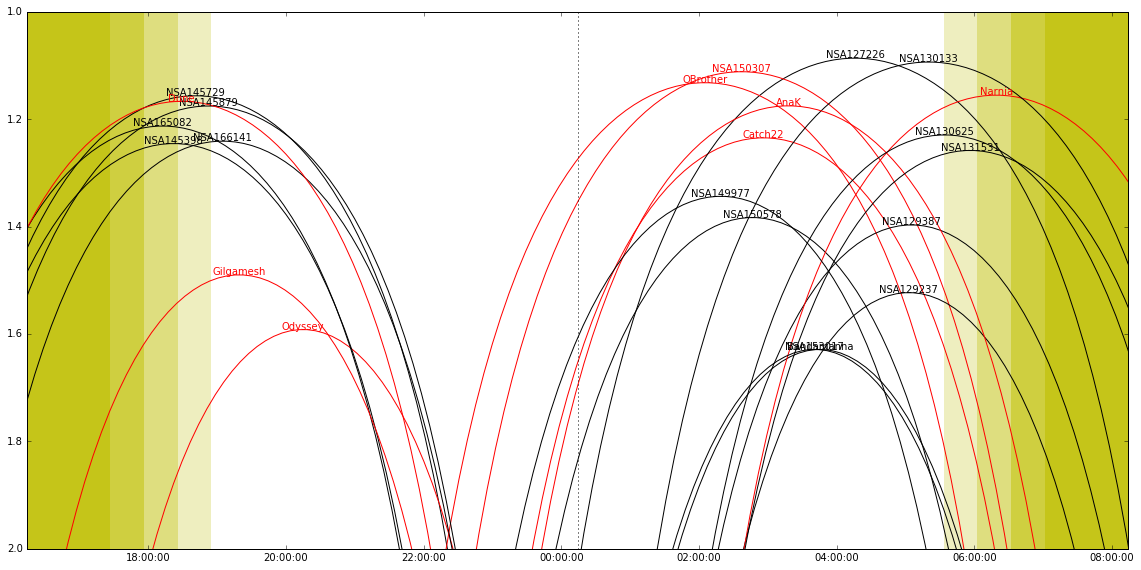

In [24]:
up_times = {}

with open('aat_targets_jul2016/aattargs_iobserve.dat', 'w') as f:
    for host in hosttab[visenough]:
        already_obs = host['NSAID'] in sagaobsed_nsaids
        
        name = 'NSA'+str(host['NSAID'])
        for nm, val in hsd.items():
            if val.nsaid == host['NSAID']:
                name = nm
                if nm.startswith('NSA'):
                    name = name+'_obsed'
                break
        
        f.write(name.replace(' ','_'))
        if already_obs:
            f.write('-observed')
        f.write(' ')
        f.write(str(host['RA']) + ' ')
        f.write(str(host['Dec']) + '\n')
        
        targ = astroplan.FixedTarget(SkyCoord(host['RA'], host['Dec'], unit=u.deg), name)
        
        tpl = (name, host['NSAID'], host['RA'], host['Dec'])
        transit = aaoobs.target_meridian_transit_time(midnight, targ)
        up_times[transit.jd] = tpl
        
        
        timestoplot = transit + np.linspace(-6, 6, 100)*u.hour
        taa = aaoobs.altaz(timestoplot, targ)
        msk = taa.secz >=1
        
        color = 'r' if already_obs else 'k'
        plt.plot(timestoplot.plot_date[msk], taa.secz[msk], c=color)
        plt.text(transit.plot_date, aaoobs.altaz(transit, targ).secz, name, ha='center', color=color)

t0 = aaoobs.sun_rise_time(midnight, 'previous')
t1 = aaoobs.sun_set_time(midnight, 'previous')
t2 = aaoobs.twilight_evening_civil(midnight, 'previous')
t3 = aaoobs.twilight_evening_nautical(midnight, 'previous')
t4 = aaoobs.twilight_evening_astronomical(midnight, 'previous')
t5 = aaoobs.twilight_morning_astronomical(midnight, 'next')
t6 = aaoobs.twilight_morning_nautical(midnight, 'next')
t7 = aaoobs.twilight_morning_civil(midnight, 'next')
t8 = aaoobs.sun_rise_time(midnight, 'next')
t9 = aaoobs.sun_set_time(midnight, 'next')

plt.fill_between([t0.plot_date,t1.plot_date],1,3, lw=0, facecolor='y', alpha=.9)
plt.fill_between([t1.plot_date,t2.plot_date],1,3, lw=0, facecolor='y', alpha=.75)
plt.fill_between([t2.plot_date,t3.plot_date],1,3, lw=0, facecolor='y', alpha=.5)
plt.fill_between([t3.plot_date,t4.plot_date],1,3, lw=0, facecolor='y', alpha=.25)
plt.fill_between([t5.plot_date,t6.plot_date],1,3, lw=0, facecolor='y', alpha=.25)
plt.fill_between([t6.plot_date,t7.plot_date],1,3, lw=0, facecolor='y', alpha=.5)
plt.fill_between([t7.plot_date,t8.plot_date],1,3, lw=0, facecolor='y', alpha=.75)
plt.fill_between([t8.plot_date,t9.plot_date],1,3, lw=0, facecolor='y', alpha=.9)

plt.axvline(midnight.plot_date, ls=':', c='k')

plt.gca().xaxis_date(aaoobs.timezone)
plt.xlim(t1.plot_date-.05, t8.plot_date+.05)
plt.ylim(2,1)
plt.tight_layout()

In [19]:
#NSA urls
for jd in sorted(up_times):
    name, nsaid, ra, dec = up_times[jd]
    print(name, 'http://www.nsatlas.org/getAtlas.html?search=nsaid&nsaID={}&submit_form=Submit'.format(nsaid))

NSA165082 http://www.nsatlas.org/getAtlas.html?search=nsaid&nsaID=165082&submit_form=Submit
NSA145398 http://www.nsatlas.org/getAtlas.html?search=nsaid&nsaID=145398&submit_form=Submit
NSA145729 http://www.nsatlas.org/getAtlas.html?search=nsaid&nsaID=145729&submit_form=Submit
NSA145879 http://www.nsatlas.org/getAtlas.html?search=nsaid&nsaID=145879&submit_form=Submit
NSA166141 http://www.nsatlas.org/getAtlas.html?search=nsaid&nsaID=166141&submit_form=Submit
NSA149977 http://www.nsatlas.org/getAtlas.html?search=nsaid&nsaID=149977&submit_form=Submit
NSA150578 http://www.nsatlas.org/getAtlas.html?search=nsaid&nsaID=150578&submit_form=Submit
NSA153017 http://www.nsatlas.org/getAtlas.html?search=nsaid&nsaID=153017&submit_form=Submit
Bandamanna http://www.nsatlas.org/getAtlas.html?search=nsaid&nsaID=126115&submit_form=Submit
NSA127226 http://www.nsatlas.org/getAtlas.html?search=nsaid&nsaID=127226&submit_form=Submit
NSA129237 http://www.nsatlas.org/getAtlas.html?search=nsaid&nsaID=129237&submit

In [20]:
# DECALS URLs
for jd in sorted(up_times):
    name, nsaid, ra, dec = up_times[jd]
    print(name, 'http://legacysurvey.org/viewer?ra={}&dec={}&zoom=8'.format(ra, dec))

NSA165082 http://legacysurvey.org/viewer?ra=217.418&dec=3.23331&zoom=8
NSA145398 http://legacysurvey.org/viewer?ra=219.796&dec=5.36347&zoom=8
NSA145729 http://legacysurvey.org/viewer?ra=224.594&dec=-1.09102&zoom=8
NSA145879 http://legacysurvey.org/viewer?ra=227.456&dec=0.470085&zoom=8
NSA166141 http://legacysurvey.org/viewer?ra=230.485&dec=5.07063&zoom=8
NSA149977 http://legacysurvey.org/viewer?ra=339.372&dec=10.5315&zoom=8
NSA150578 http://legacysurvey.org/viewer?ra=346.236&dec=12.3229&zoom=8
NSA153017 http://legacysurvey.org/viewer?ra=359.856&dec=20.7498&zoom=8
Bandamanna http://legacysurvey.org/viewer?ra=0.995575&dec=20.7524&zoom=8
NSA127226 http://legacysurvey.org/viewer?ra=8.69484&dec=-8.39644&zoom=8
NSA129237 http://legacysurvey.org/viewer?ra=20.449&dec=17.5922&zoom=8
NSA129387 http://legacysurvey.org/viewer?ra=21.0163&dec=12.9175&zoom=8
NSA130133 http://legacysurvey.org/viewer?ra=24.7772&dec=-7.51266&zoom=8
NSA130625 http://legacysurvey.org/viewer?ra=28.3054&dec=4.19576&zoom=8
N

Notes:
* NSA165082: in DECALS DR2, only z-band, looks like a group, elliptical
* NSA145398: in DECALS DR2, z-band and a bit of g and r, elliptical, otherwise good
* NSA145729: in DECALS DR2, z-band and some r, OK but somewhat near SDSS edge?
* NSA145879: in DECALS DR2, z-band and some g and r, elliptical, otherwise good
* NSA166141: in DECALS DR2, z-band and some g and r, otherwise good
* NSA149977: in DECALS DR2, z-band and some g and r, otherwise good
* NSA150578: in DECALS DR2, only z-band, otherwise good
* NSA153017: in DECALS DR2, only z-band, otherwise good
* Bandamanna: in DECALS DR2, only z-band, otherwise good
* NSA127226: otherwise good
* NSA129237: in DECALS DR2, only z-band, otherwise good
* NSA129387: otherwise good
* NSA130133: elliptical? otherwise good
* NSA130625: S0? otherwise good
* NSA131531: near SDSS edge, otherwise good